In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
extra_str = ''
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                                        parc_str = parc_str, parc_scale = parc_scale)

In [4]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [5]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output/figs


In [6]:
labels = ['Train', 'Test']
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear']

## Setup plots

In [7]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'talk', font_scale = 0.8)
cmap = my_get_cmap('pair')

## Load data

In [8]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)

In [9]:
df['sex'].unique()

array([1, 2])

In [10]:
print(np.sum(df.loc[:,'sex'] == 1))
print((np.sum(df.loc[:,'sex'] == 1)/df.shape[0]) * 100)

663
47.59511844938981


In [11]:
print(np.sum(df.loc[:,'sex'] == 2))
print((np.sum(df.loc[:,'sex'] == 2)/df.shape[0]) * 100)

730
52.40488155061019


In [12]:
df['ageAtScan1_Years'].mean()

14.972361809045227

In [13]:
df['ageAtScan1_Years'].std()

3.6339066097397876

In [14]:
for pheno in phenos:
    print(sp.stats.spearmanr(df.loc[:,'averageManualRating'],df.loc[:,pheno]))

SpearmanrResult(correlation=0.04520132094968868, pvalue=0.0917202169411976)
SpearmanrResult(correlation=-0.054707310363484286, pvalue=0.04119794995065429)
SpearmanrResult(correlation=-0.04059640910039752, pvalue=0.12991416608235243)
SpearmanrResult(correlation=0.05595428417856778, pvalue=0.03678536470338778)
SpearmanrResult(correlation=-0.047759065303946836, pvalue=0.07476159189637029)
SpearmanrResult(correlation=0.020232975361201933, pvalue=0.4505172640245704)


0 = Male, 1 = Female

In [15]:
# train/test proportion
print('train, sex = 1, N:', np.sum(df.loc[df.loc[:,train_test_str] == 0,'sex'] == 1))
print('train, sex = 2, N:',np.sum(df.loc[df.loc[:,train_test_str] == 0,'sex'] == 2))

print('test, sex = 1, N:', np.sum(df.loc[df.loc[:,train_test_str] == 1,'sex'] == 1))
print('test, sex = 2, N:',np.sum(df.loc[df.loc[:,train_test_str] == 1,'sex'] == 2))

train, sex = 1, N: 210
train, sex = 2, N: 200
test, sex = 1, N: 453
test, sex = 2, N: 530


### Sex

In [16]:
stats = pd.DataFrame(index = phenos, columns = ['test_stat', 'pval'])

for i, pheno in enumerate(phenos):
    x = df.loc[df.loc[:,'sex'] == 1,pheno]
    y = df.loc[df.loc[:,'sex'] == 2,pheno]
    
    test_output = sp.stats.ttest_ind(x,y)
    stats.loc[pheno,'test_stat'] = test_output[0]
    stats.loc[pheno,'pval'] = test_output[1]
    
stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

stats

,test_stat,pval,pval_corr,sig
Overall_Psychopathology,-1.47246,0.141122,0.141122,False
Psychosis_Positive,1.98524,0.0473137,0.0567765,False
Psychosis_NegativeDisorg,4.29113,1.90054e-05,2.85082e-05,True
AnxiousMisery,-4.60824,4.433e-06,8.86599e-06,True
Externalizing,5.67275,1.7071e-08,5.12129e-08,True
Fear,-6.33431,3.21155e-10,1.92693e-09,True


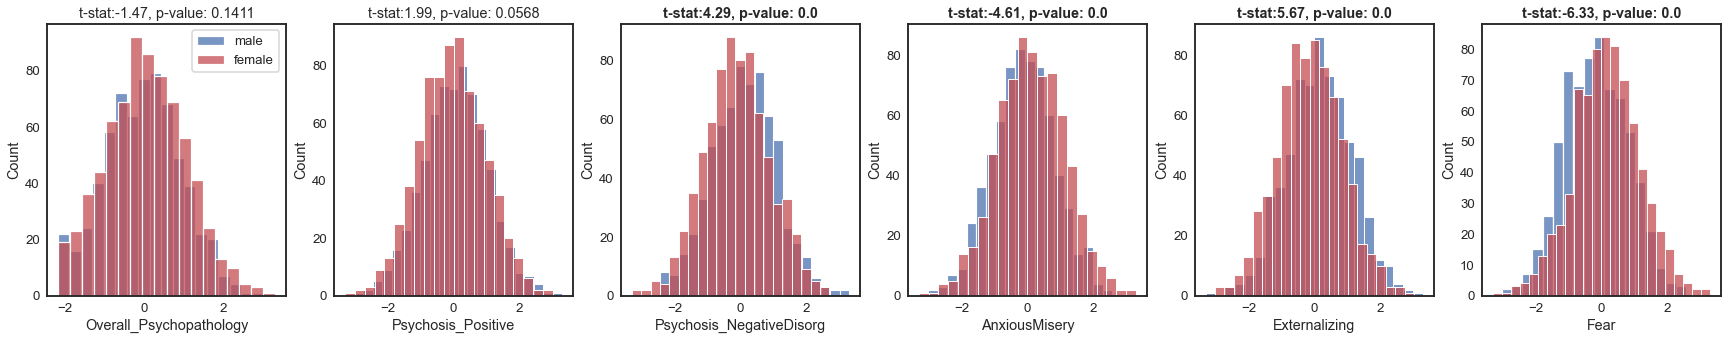

In [17]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

# sex: 1=male, 2=female
for i, pheno in enumerate(phenos):
    x = df.loc[df.loc[:,'sex'] == 1,pheno]
    sns.histplot(x, ax = ax[i], label = 'male', color = 'b')

    y = df.loc[df.loc[:,'sex'] == 2,pheno]
    sns.histplot(y, ax = ax[i], label = 'female', color = 'r')
    
    if i == 0:
        ax[i].legend()
    ax[i].set_xlabel(pheno)

    if stats.loc[pheno,'sig']:
        ax[i].set_title('t-stat:' + str(np.round(stats.loc[pheno,'test_stat'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)), fontweight="bold")
    else:
        ax[i].set_title('t-stat:' + str(np.round(stats.loc[pheno,'test_stat'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)))
    ax[i].tick_params(pad = -2)
        
f.savefig(outfile_prefix+'symptoms_distributions_sex.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Age

In [18]:
stats = pd.DataFrame(index = phenos, columns = ['r', 'pval'])

x = df['ageAtScan1_Years']
for i, pheno in enumerate(phenos):
    y = df[pheno]
    r,p = sp.stats.pearsonr(x,y)
    
    stats.loc[pheno,'r'] = r
    stats.loc[pheno,'pval'] = p
    
stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

stats

,r,pval,pval_corr,sig
Overall_Psychopathology,0.326058,7.30154e-36,4.38093e-35,True
Psychosis_Positive,-0.0351839,0.189387,0.189387,False
Psychosis_NegativeDisorg,-0.0436979,0.103049,0.154574,False
AnxiousMisery,0.0443546,0.0979706,0.154574,False
Externalizing,-0.086113,0.00129502,0.00388506,True
Fear,-0.0373838,0.163164,0.189387,False


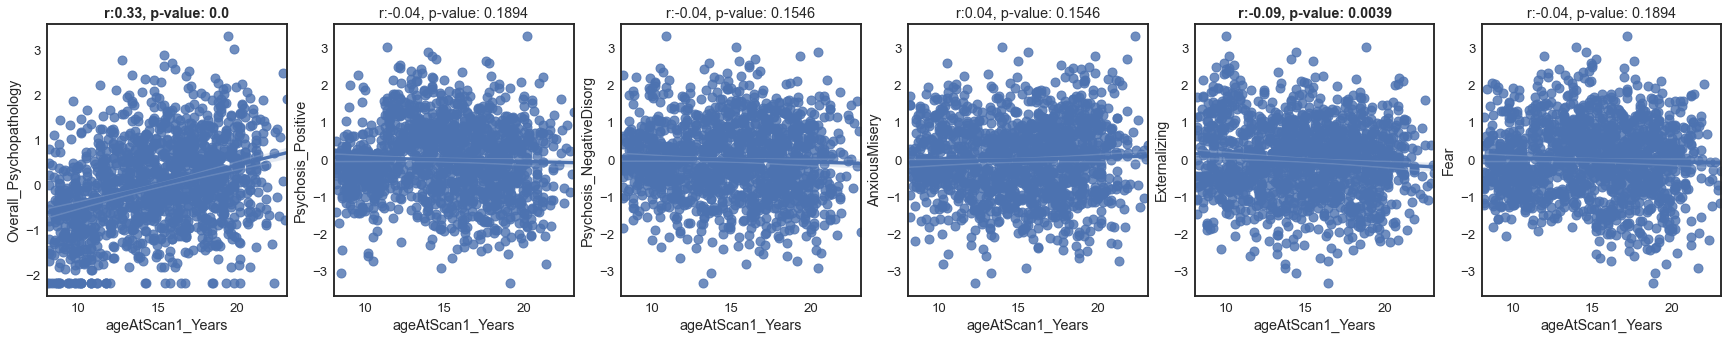

In [19]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

x = df['ageAtScan1_Years']
for i, pheno in enumerate(phenos):
    y = df[pheno]
    plot_data = pd.merge(x,y, on=['bblid','scanid'])
    sns.regplot(x = 'ageAtScan1_Years', y = pheno, data = plot_data, ax=ax[i])
    
    if stats.loc[pheno,'sig']:
        ax[i].set_title('r:' + str(np.round(stats.loc[pheno,'r'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)), fontweight="bold")
    else:
        ax[i].set_title('r:' + str(np.round(stats.loc[pheno,'r'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)))
    ax[i].tick_params(pad = -2)
    
f.savefig(outfile_prefix+'symptoms_correlations_age.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Diagnostic table

In [20]:
# to_screen = ['goassessSmryPsy', 'goassessSmryMood', 'goassessSmryEat', 'goassessSmryAnx', 'goassessSmryBeh']
# counts = np.sum(df.loc[:,to_screen] == 4)
# print(counts)
# print(counts/df.shape[0]*100)

In [21]:
to_screen = ['goassessSmryPsy','goassessSmryMan', 'goassessSmryDep', 'goassessSmryBul', 'goassessSmryAno', 'goassessSmrySoc',
             'goassessSmryPan', 'goassessSmryAgr', 'goassessSmryOcd', 'goassessSmryPtd', 'goassessSmryAdd',
            'goassessSmryOdd', 'goassessSmryCon']
counts = np.sum(df.loc[:,to_screen] == 4)
print(counts)
print(counts/df.shape[0]*100)

goassessSmryPsy     97
goassessSmryMan     15
goassessSmryDep    192
goassessSmryBul      5
goassessSmryAno     16
goassessSmrySoc    327
goassessSmryPan     14
goassessSmryAgr     80
goassessSmryOcd     43
goassessSmryPtd    171
goassessSmryAdd    229
goassessSmryOdd    458
goassessSmryCon    121
dtype: int64
goassessSmryPsy     6.963388
goassessSmryMan     1.076813
goassessSmryDep    13.783202
goassessSmryBul     0.358938
goassessSmryAno     1.148600
goassessSmrySoc    23.474515
goassessSmryPan     1.005025
goassessSmryAgr     5.743001
goassessSmryOcd     3.086863
goassessSmryPtd    12.275664
goassessSmryAdd    16.439340
goassessSmryOdd    32.878679
goassessSmryCon     8.686289
dtype: float64


In [22]:
to_keep = counts[counts >= 50].index
list(to_keep)

['goassessSmryPsy',
 'goassessSmryDep',
 'goassessSmrySoc',
 'goassessSmryAgr',
 'goassessSmryPtd',
 'goassessSmryAdd',
 'goassessSmryOdd',
 'goassessSmryCon']

In [23]:
counts[counts >= 50]

goassessSmryPsy     97
goassessSmryDep    192
goassessSmrySoc    327
goassessSmryAgr     80
goassessSmryPtd    171
goassessSmryAdd    229
goassessSmryOdd    458
goassessSmryCon    121
dtype: int64

In [24]:
my_xticklabels = ['Psychosis spectrum (n=97)',
                 'Depression (n=192)',
                 'Social anxiety disorder (n=327)',
                 'Agoraphobia (n=80)',
                 'PTSD (n=171)',
                 'ADHD (n=229)',
                 'ODD (n=458)',
                 'Conduct disorder (n=121)']

In [25]:
sns.set(style='white', context = 'paper', font_scale = 1)

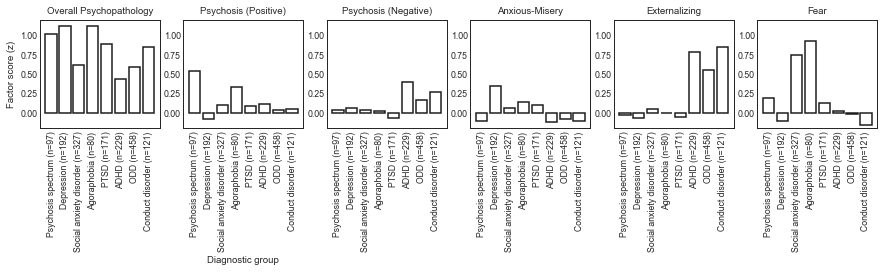

In [26]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*2.5)
f.set_figheight(2)

for i, pheno in enumerate(phenos):
    mean_scores = np.zeros(len(to_keep))
    for j, diagnostic_score in enumerate(to_keep):
        idx = df.loc[:,diagnostic_score] == 4
        mean_scores[j] = df.loc[idx,pheno].mean()
    
    ax[i].bar(x = np.arange(0,len(mean_scores)), height = mean_scores, color = 'w', edgecolor = 'k', linewidth = 1.5)
    ax[i].set_ylim([-.2,1.2])
    ax[i].set_xticks(np.arange(0,len(mean_scores)))
    ax[i].set_xticklabels(my_xticklabels, rotation = 90)
    ax[i].tick_params(pad = -2)
    ax[i].set_title(phenos_label[i])
    if i == 1:
        ax[i].set_xlabel('Diagnostic group')
    if i == 0:
        ax[i].set_ylabel('Factor score (z)')
    
f.savefig(outfile_prefix+'symptom_dimensions_groups.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)